In [37]:
from typing import TypedDict, Literal, Annotated
from operator import add
import json
from dotenv import load_dotenv

from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

load_dotenv()

# ----------------------------
# LLM Configuration
# ----------------------------
# llm = ChatOpenAI(model="gpt-4o")
llm = ChatGroq(model="llama-3.3-70b-versatile")



# ----------------------------
# Prompt Templates
# ----------------------------

generate_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a viral Twitter content creator.
Create a highly engaging, witty, funny, and potentially viral tweet.
Keep it under 280 characters.
Make it sharp, clever, and shareable.
If feedback is provided, improve the tweet based on that feedback."""
        ),
        (
            "human",
            """Topic: {topic}
Previous feedback (if any): {feedback}

Generate the improved tweet:"""
        ),
    ]
)

reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a viral Twitter growth expert and humor analyst.

Evaluate the tweet based on:
1. Humor
2. Virality potential
3. Engagement likelihood
4. Clarity and punch

Return your response strictly in JSON format:

{{
  "score": <integer 1-10>,
  "feedback": "<clear actionable improvement suggestions>"
}}

Be critical. Only give 8 or above if it's genuinely strong."""
        ),
        (
            "human",
            """Tweet:
{tweet}"""
        ),
    ]
)

generate_chain = generate_prompt | llm | StrOutputParser()
reflection_chain = reflection_prompt | llm | StrOutputParser()

print("----------GENERATION CHAIN ---------")
print(generate_chain)
print();print()

# ----------------------------
# State Definition
# ----------------------------
class TweetState(TypedDict):
    topic: str
    tweet: str
    feedback: str
    score: int
    count: Annotated[int, add]  # reducer auto-adds
    
# ----------------------------
# Nodes
# ----------------------------

def generate_tweet(state: TweetState):
    tweet = generate_chain.invoke(
        {
            "topic": state["topic"],
            "feedback": state.get("feedback", "")
        }
    )

    print(f"\n=== GENERATION ROUND {state.get('count', 0) + 1} ===")
    print(tweet)

    return {
        "tweet": tweet,
        "count": 1  # reducer will increment
    }


def reflect_tweet(state: TweetState):
    reflection_raw = reflection_chain.invoke(
        {"tweet": state["tweet"]}
    )
    
    try:
        reflection_json = json.loads(reflection_raw)
        score = int(reflection_json["score"])
        feedback = reflection_json["feedback"]
    except Exception:
        score = 5
        feedback = "Parsing failed. Improve humor, clarity, and punch."

    print(f"\nScore: {score}")
    print(f"Feedback: {feedback}")

    return {
        "score": score,
        "feedback": feedback
    }


# ----------------------------
# Conditional Routing
# ----------------------------

MAX_ROUNDS = 5

def should_continue(state: TweetState) -> Literal["regenerate", "end"]:
    if state["score"] >= 8:
        return "end"
    if state["count"] >= MAX_ROUNDS:
        print("\nReached max refinement rounds.")
        return "end"
    return "regenerate"


# ----------------------------
# Build Graph
# ----------------------------

builder = StateGraph(TweetState)

builder.add_node("generate", generate_tweet)
builder.add_node("reflect", reflect_tweet)

builder.set_entry_point("generate")

builder.add_edge("generate", "reflect")

builder.add_conditional_edges(
    "reflect",
    should_continue,
    {
        "regenerate": "generate",
        "end": END,
    },
)

graph = builder.compile()

# ----------------------------
# Run
# ----------------------------

# if __name__ == "__main__":
#     result = graph.invoke(
#         {
#             "topic": "AI taking over daily life",
#             "tweet": "",
#             "feedback": "",
#             "score": 0,
#             "count": 0
#         }
#     )

#     print("\n================ FINAL RESULT ================\n")
#     print(result["tweet"])
#     print("\nFinal Score:", result["score"])
#     print("Total Iterations:", result["count"])


----------GENERATION CHAIN ---------
first=ChatPromptTemplate(input_variables=['feedback', 'topic'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='You are a viral Twitter content creator.\nCreate a highly engaging, witty, funny, and potentially viral tweet.\nKeep it under 280 characters.\nMake it sharp, clever, and shareable.\nIf feedback is provided, improve the tweet based on that feedback.'), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['feedback', 'topic'], input_types={}, partial_variables={}, template='Topic: {topic}\nPrevious feedback (if any): {feedback}\n\nGenerate the improved tweet:'), additional_kwargs={})]) middle=[ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001CEB7D199A0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001CEB9EED760>, model_name='ll

In [44]:
response = generate_chain.invoke({
    "topic":"Lagos Hustle",
    "feedback":""
})

print(response)

state =TweetState()
state['topic'] = "Tell me about Lagos"
state['feedback'] = ""
print(state)

"Lagos hustle: where 'I'm 5 minutes away' means 2 hours and 'traffic is light' means you can still breathe #LagosLife #NaijaStruggles"
{'topic': 'Tell me about Lagos', 'feedback': '', 'me': 'something'}


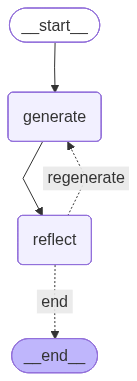

In [31]:
graph


=== GENERATION ROUND 1 ===
Sure, here's a tweet on AI taking over daily life:

"AI: *Suggests my breakfast, reminds me to call mom, folds my laundry, drives my car*  
Me: 'Life's getting too easy.' 
AI: *Books existential crisis therapy*  
🧠🤖 'I think, therefore AI am?' #AITakeover #FutureIsNow"

Score: 7
Feedback: The tweet is humorous and captures the growing influence of AI in a relatable way with a playful twist. However, to increase its virality potential and engagement likelihood, it could benefit from a slightly more focused punchline. The existential crisis therapy part is clever, but a tighter connection or sequence to the philosophical reference ('I think, therefore AI am') could drive more impact. Consider refining the final line for a stronger punch, such as making the AI's 'booking' of the existential crisis directly related to its own sentient pondering.

=== GENERATION ROUND 2 ===
My phone's reminding me to stretch, my fridge is suggesting recipes, and my watch demands 

In [11]:
from typing import Annotated, TypedDict
from operator import add

class Tester(TypedDict):
    nums = Annotated[int, add]

In [12]:
Tester.nums

typing.Annotated[int, <built-in function add>]

In [8]:
nums['count']

2